<a href="https://colab.research.google.com/github/MengOonLee/Deep_learning/blob/master/PyTorch/Experiments/Transformer/TimeSeries/T01_Forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Packages

In [1]:
import os
import time
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
import torch

seed = 42
np.random.seed(seed=seed)
torch.manual_seed(seed=seed)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


### Time Series

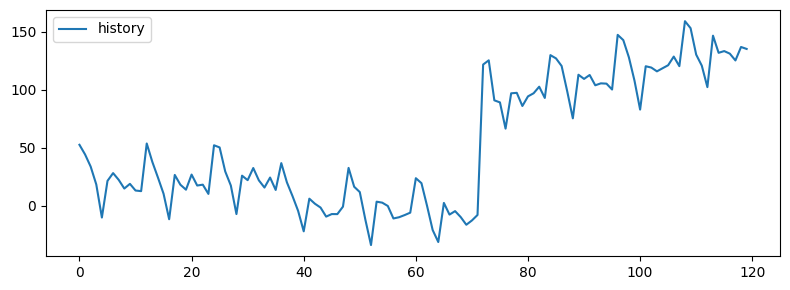

In [2]:
# -------------------------
# Synthetic data generation
# -------------------------

def trend(time):
    # piecewise linear trend
    slope = np.zeros_like(a=time)
    slope[time < (3*12)] = 0.2
    slope[(time >= (3*12)) & (time < (6*12))] = -0.4
    slope[time >= (6*12)] = 1.0
    return slope * time

def seasonal_pattern(season_time):
    return np.where(season_time < 0.4, np.cos(season_time * 2 * np.pi),
        1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    season_time = ((time + phase) % period) / float(period)
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=5, seed=seed):
    rnd = np.random.RandomState(seed=seed)
    return rnd.randn(len(time)) * noise_level

def make_time_series():
    period = 12; baseline = 10; amplitude = 40
    time_history = np.arange(10*12, dtype=np.float32)
    ts_history = baseline + trend(time=time_history)\
        + seasonality(time=time_history, period=period, amplitude=amplitude)\
        + noise(time=time_history)
    ts_history = ts_history.astype(np.float32)
    return time_history, ts_history

# generate data
time_history, ts_history = make_time_series()
plt.figure(figsize=(8, 3))
sns.lineplot(x=time_history, y=ts_history, label='history')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

### Dataset & DataLoader

In [3]:
# -------------------------
# Dataset and DataLoader
# -------------------------

src_len = 24; tgt_len = 12
# split: reserve last (src_len+tgt_len) for test-like sequences
ts_train = ts_history[:-tgt_len]
ts_test = ts_history[-(src_len+tgt_len):]

# scaler fit on train
scaler = preprocessing.MinMaxScaler(feature_range=(-1, 1))
scaler.fit(X=ts_train.reshape(-1, 1))
ts_train = scaler.transform(X=ts_train.reshape(-1, 1)).flatten()
ts_test = scaler.transform(X=ts_test.reshape(-1, 1)).flatten()

class TrainingDataset(torch.utils.data.Dataset):
    def __init__(self, ts, src_len, tgt_len, add_rolling=True):
        # ts: 1D numpy array already scaled (float32)
        super().__init__()
        self.ts = torch.tensor(data=ts, dtype=torch.float32).view(-1, 1)
        self.src_len = src_len; self.tgt_len = tgt_len
        self.idxs = list(range(len(ts) - (src_len+tgt_len) + 1))
        self.add_rolling = add_rolling
        # precompute rolling stats for efficiency
        arr = ts.flatten()
        self.rolling_mean_3 = pd.Series(data=arr)\
            .rolling(window=3, min_periods=1).mean().values.astype(np.float32)
        self.rolling_mean_6 = pd.Series(data=arr)\
            .rolling(window=6, min_periods=1).mean().values.astype(np.float32)

    def __len__(self):
        return len(self.idxs)

    def __getitem__(self, idx):
        data = {}
        i = self.idxs[idx]

        src_start = i; src_end = i+self.src_len
        data['src'] = self.ts[src_start:src_end] # (src_len, 1)
        data['src_idx'] = torch.arange(start=src_start, end=src_end,
            dtype=torch.long)
        data['src_month'] = (data['src_idx'] % 12).long()

        tgt_start = i+self.src_len; tgt_end = i+self.src_len+self.tgt_len
        data['tgt'] = self.ts[tgt_start:tgt_end]
        data['tgt_idx'] = torch.arange(start=tgt_start, end=tgt_end,
            dtype=torch.long)
        data['tgt_month'] = (data['tgt_idx'] % 12).long()

        if self.add_rolling:
            # rolling means: per time-step scalar
            data['src_rm3'] = torch.tensor(data=self.rolling_mean_3[
                src_start:src_end], dtype=torch.float32).view(-1, 1)
            data['src_rm6'] = torch.tensor(data=self.rolling_mean_6[
                src_start:src_end], dtype=torch.float32).view(-1, 1)
            # tgt rolling features for completeness
            data['tgt_rm3'] = torch.tensor(data=self.rolling_mean_3[
                tgt_start:tgt_end], dtype=torch.float32).view(-1, 1)
            data['tgt_rm6'] = torch.tensor(data=self.rolling_mean_6[
                tgt_start:tgt_end], dtype=torch.float32).view(-1, 1)

        return {k: v for k, v in data.items()}

def collate_fn(batch):
    # Batch is a list of dicts; stack into tensors
    out = {}
    for key in batch[0].keys():
        out[key] = torch.stack([b[key] for b in batch], dim=0)
    return out

# Datasets and loaders (create sliding windows)
batch_size = 32
ds_train = TrainingDataset(ts=ts_train, src_len=src_len, tgt_len=tgt_len,
    add_rolling=True)
dl_train = torch.utils.data.DataLoader(dataset=ds_train, shuffle=True,
    batch_size=batch_size, collate_fn=collate_fn)

ds_test = TrainingDataset(ts=ts_test, src_len=src_len, tgt_len=tgt_len,
    add_rolling=True)
dl_test = torch.utils.data.DataLoader(dataset=ds_test, shuffle=False,
    batch_size=batch_size, collate_fn=collate_fn)

data = next(iter(dl_test))
print({k: v.shape for k, v in data.items()})

{'src': torch.Size([1, 24, 1]), 'src_idx': torch.Size([1, 24]), 'src_month': torch.Size([1, 24]), 'tgt': torch.Size([1, 12, 1]), 'tgt_idx': torch.Size([1, 12]), 'tgt_month': torch.Size([1, 12]), 'src_rm3': torch.Size([1, 24, 1]), 'src_rm6': torch.Size([1, 24, 1]), 'tgt_rm3': torch.Size([1, 12, 1]), 'tgt_rm6': torch.Size([1, 12, 1])}


### Model

In [4]:
# -------------------------
# Model definitions
# -------------------------

class PositionalEncoding(torch.nn.Module):
    def __init__(self, d_model, max_len=50*12):
        super().__init__()
        pe = torch.zeros(size=(max_len, d_model))
        position = torch.arange(start=0, end=max_len, dtype=torch.float32)\
            .unsqueeze(dim=1)
        div_term = torch.exp(torch.arange(start=0, end=d_model, step=2)
            .float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        # (1, max_len, d_model)
        self.register_buffer('pe', pe.unsqueeze(dim=0))

    def forward(self, x):
        # x: (B, T, d_model)
        x = x + self.pe[:, :x.size(1)]
        return x

class TransformerForecast(torch.nn.Module):
    def __init__(self, num_in_features=1, num_out_features=1, d_model=128,
            time_emb_dim=16, nhead=4, num_layers=2, dropout=0.2,
            max_len=50*12):
        super().__init__()

        # value projection
        self.input_proj = torch.nn.Sequential(
            torch.nn.Linear(in_features=num_in_features,
                out_features=d_model),
            torch.nn.LayerNorm(normalized_shape=d_model),
            torch.nn.Dropout(p=dropout)
        )

        # time embeddings: index & month embedding
        self.idx_emb = torch.nn.Embedding(embedding_dim=time_emb_dim//2,
            num_embeddings=max_len)
        self.month_emb = torch.nn.Embedding(embedding_dim=time_emb_dim//2,
            num_embeddings=12)

        # small linear to map time features to model dim
        self.time_proj = torch.nn.Sequential(
            # +2 for sin/cos seasonal continuous features
            torch.nn.Linear(in_features=time_emb_dim+2, out_features=d_model),
            torch.nn.LayerNorm(normalized_shape=d_model),
            torch.nn.Dropout(p=dropout)
        )

        self.positional = PositionalEncoding(d_model=d_model, max_len=max_len)

        encoder_layer = torch.nn.TransformerEncoderLayer(d_model=d_model,
            nhead=nhead, batch_first=True, dropout=dropout)
        self.encoder = torch.nn.TransformerEncoder(num_layers=num_layers,
            encoder_layer=encoder_layer)

        decoder_layer = torch.nn.TransformerDecoderLayer(d_model=d_model,
            nhead=nhead, batch_first=True, dropout=dropout)
        self.decoder = torch.nn.TransformerDecoder(num_layers=num_layers,
            decoder_layer=decoder_layer)

        self.output_proj = torch.nn.Sequential(
            torch.nn.Linear(in_features=d_model,
                out_features=num_out_features)
        )

    def make_time_feats(self, idx):
        # idx: (B, T) long
        idx = idx.long()
        month = (idx % 12).long()
        idx_emb = self.idx_emb(idx) # (B, T, emb//2)
        month_emb = self.month_emb(month) # (B, T, emb//2)
        base = torch.cat(tensors=[idx_emb, month_emb], dim=-1) # (B, T, emb)
        # also add sin/cos seasonal continuous features
        month_float = (month.float() / 12.0) # [0, 1)
        sin = torch.sin(2 * math.pi * month_float).unsqueeze(dim=-1)
        cos = torch.cos(2 * math.pi * month_float).unsqueeze(dim=-1)
        time_feats = torch.cat(tensors=[base, sin, cos], dim=-1)
        return time_feats

    def forward(self, data):
        # data fields: src(B, src_len, 1), src_idx(B, src_len),
        # tgt(B, tgt_len, 1), tgt_idx(B, tgt_len)
        src = data['src'].float()
        tgt = data['tgt'].float()
        src_idx = data['src_idx']
        tgt_idx = data['tgt_idx']

        # Optionally include rolling features (if present)
        if 'src_rm3' in data:
            src_feats = torch.cat(tensors=[src, data['src_rm3'],
                data['src_rm6']], dim=-1) # (B, src_len, 3)
            # project multi-dim to d_model with a linear layer
            src = self.input_proj(src_feats)
        else:
            src = self.input_proj(src) # (B, src_len, d_model)

        src_time = self.make_time_feats(idx=src_idx)
        src_time = self.time_proj(src_time) # (B, src_len, d_model)
        src = self.positional(src+src_time) # (B, src_len, d_model)
        memory = self.encoder(src) # (B, src_len, d_model)

        # decoder
        if 'tgt_rm3' in data:
            tgt_feats = torch.cat(tensors=[tgt, data['tgt_rm3'],
                data['tgt_rm6']], dim=-1)
            tgt = self.input_proj(tgt_feats)
        else:
            tgt = self.input_proj(tgt)

        tgt_time = self.make_time_feats(idx=tgt_idx)
        tgt_time = self.time_proj(tgt_time)
        tgt = self.positional(tgt+tgt_time)

        tgt_mask = torch.nn.Transformer.generate_square_subsequent_mask(
            sz=tgt.size(1)).to(tgt.device)
        # (B, tgt_len, d_model)
        out = self.decoder(tgt=tgt, memory=memory, tgt_mask=tgt_mask)
        return self.output_proj(out) # (B, tgt_len, num_features)

    def infer(self, data, tgt_len=12, device=None):
               # Autoregressive inference (no teacher forcing)
        # data['src'], data['src_idx'] provided;
        # we will autoregressively build tgt with last src as start
        if device is None:
            device = next(self.parameters()).device

        src = data['src']; src_idx = data['src_idx']
        B = src.size(0)
        # initialize tgt with last src value
        last_val = src[:, -1:, :].to(device) # (B, 1, 1)
        last_idx = src_idx[:, -1:].to(device) # (B, 1)
        last_month = (last_idx % 12).long()

        # start tgt tensors
        tgt = last_val
        tgt_idx = last_idx
        # build rolling features for the first step by using last values
        if 'src_rm3' in data:
            last_rm3 = data['src_rm3'][:, -1:, :].to(device)
            last_rm6 = data['src_rm6'][:, -1:, :].to(device)
            tgt_rm3 = last_rm3; tgt_rm6 = last_rm6
        else:
            tgt_rm3 = None; tgt_rm6 = None

        preds = []
        # resuse data['src'] and its idx for encoder
        data_for_encoder = {
            'src': data['src'].to(device),
            'src_idx': data['src_idx'].to(device),
            'src_month': (data['src_idx'] % 12).long().to(device)
        }
        if 'src_rm3' in data:
            data_for_encoder['src_rm3'] = data['src_rm3'].to(device)
            data_for_encoder['src_rm6'] = data['src_rm6'].to(device)

        # compute memory once
        with torch.no_grad():
            src = data_for_encoder['src']
            src_idx = data_for_encoder['src_idx']
            # build a small data dict to call encoder half of forward
            enc_dict = {
                'src': src,
                'src_idx': src_idx,
                'tgt': torch.zeros_like(tgt),
                'tgt_idx': tgt_idx
            }
            if 'src_rm3' in data_for_encoder:
                enc_dict['src_rm3'] = data_for_encoder['src_rm3']
                enc_dict['src_rm6'] = data_for_encoder['src_rm6']

            src_feats = torch.cat(tensors=[
                enc_dict['src'],
                enc_dict.get('src_rm3', torch.zeros_like(enc_dict['src'])),
                enc_dict.get('src_rm6', torch.zeros_like(enc_dict['src']))
            ], dim=-1)
            src_rep = self.input_proj(src_feats)
            src_time = self.make_time_feats(idx=src_idx)
            src_time = self.time_proj(src_time)
            # get memory, memory is shaped (B, src_len, d_model)
            memory = self.encoder(self.positional(src_rep + src_time))

            for _ in range(tgt_len):
                # build minimal data dict for decoder input
                dec_dict = {
                    'src': data_for_encoder['src'],
                    'src_idx': data_for_encoder['src_idx'],
                    'tgt': tgt,
                    'tgt_idx': tgt_idx
                }
                if tgt_rm3 is not None:
                    dec_dict['tgt_rm3'] = tgt_rm3
                    dec_dict['tgt_rm6'] = tgt_rm6

                # compute decoder output using memory
                if 'tgt_rm3' in dec_dict:
                    tgt_feats = torch.cat(tensors=[
                        dec_dict['tgt'], dec_dict['tgt_rm3'],
                        dec_dict['tgt_rm6']
                    ], dim=-1)
                    tgt_rep = self.input_proj(tgt_feats)
                else:
                    tgt_rep = self.input_proj(dec_dict['tgt'])
                tgt_time = self.make_time_feats(idx=dec_dict['tgt_idx'])
                tgt_time = self.time_proj(tgt_time)
                tgt_rep = self.positional(tgt_rep + tgt_time)

                tgt_mask = torch.nn.Transformer\
                    .generate_square_subsequent_mask(sz=tgt_rep.size(1))\
                    .to(tgt.device)
                dec_out = self.decoder(tgt=tgt_rep, memory=memory,
                    tgt_mask=tgt_mask)
                pred_step = self.output_proj(dec_out[:, -1:, :]) # (B, 1, 1)
                preds.append(pred_step)

                # append for next step
                tgt = torch.cat(tensors=[tgt, pred_step], dim=1)
                new_idx = tgt_idx[:, -1:] + 1
                tgt_idx = torch.cat(tensors=[tgt_idx, new_idx], dim=1)
                # rolling features: naive update using previous values
                if tgt_rm3 is not None:
                    # shift and append last predicted value for rolling mean
                    prev_rm3 = tgt_rm3[:, -1:, :].clone()
                    prev_rm6 = tgt_rm6[:, -1:, :].clone()
                    # compute simple rolling update
                    new_rm3 = (prev_rm3 * 2 + pred_step) / 3.0
                    new_rm6 = (prev_rm6 * 2 + pred_step) / 6.0
                    tgt_rm3 = torch.cat(tensors=[tgt_rm3, new_rm3], dim=1)
                    tgt_rm6 = torch.cat(tensors=[tgt_rm6, new_rm6], dim=1)

        preds = torch.cat(tensors=preds, dim=1) # (B, tgt_len, 1)
        return preds

# we concatenated value + rm3 + rm6 in the input projection
model = TransformerForecast(num_in_features=3, num_out_features=1,
    d_model=128, time_emb_dim=16, nhead=4, num_layers=2, dropout=0.15)\
    .to(device)

total_params = sum(p.numel() for p in model.parameters())
print("Total model parameters: %d"%(total_params))

model.eval()
with torch.no_grad():
    out = model.infer(data=data, tgt_len=tgt_len)
print(out.shape)

Total model parameters: 2513185
torch.Size([1, 12, 1])


### Training

In [5]:
# -------------------------
# Training utilities
# -------------------------

def train_step_scheduled(model, dl_train, loss_fn, optimizer, device,
        teacher_forcing_prob=1.0):
    model.train()
    losses = []
    for batch in dl_train:
        # move to device
        batch = {k: v.to(device) for k, v in batch.items()}
        # y_true
        y_true = batch['tgt'] # (B, tgt_len, 1)

        # Prepare decoder initial sequences: use last src value then
        # shift tgt by one (teacher forcing start)
        dec_init = torch.cat(tensors=[
            batch['src'][:, -1:, :], batch['tgt'][:, :-1, :]
        ], dim=1) # (B, tgt_len, 1)
        dec_idx_init = torch.cat(tensors=[
            batch['src_idx'][:, -1:], batch['tgt_idx'][:, :-1]
        ], dim=1)
        # rolling features for decoder
        if 'src_rm3' in batch:
            dec_rm3_init = torch.cat(tensors=[
                batch['src_rm3'][:, -1:, :], batch['tgt_rm3'][:, :-1, :]
            ], dim=1)
            dec_rm6_init = torch.cat(tensors=[
                batch['src_rm6'][:, -1:, :], batch['tgt_rm6'][:, :-1, :]
            ], dim=1)
        else:
            dec_rm3_init=None; dec_rm6_init=None

        # an autoregressive rollout, replace some targets with model preds
        B, T, _ = dec_init.shape
        # Initialize the sequences for the decoder for the first step
        dec_in = dec_init.clone()
        dec_idx = dec_idx_init.clone()
        if dec_rm3_init is not None:
            dec_rm3_in = dec_rm3_init.clone()
            dec_rm6_in = dec_rm6_init.clone()
        else:
            dec_rm3_in = None; dec_rm6_in = None

        preds = []
        for t in range(T):
            # build data dict expected by model forward
            data = {
                'src': batch['src'],
                'src_idx': batch['src_idx'],
                # Pass the accumulated sequence
                'tgt': dec_in[:, :t+1, :],
                'tgt_idx': dec_idx[:, :t+1]
            }
            if dec_rm3_in is not None:
                data['src_rm3'] = batch['src_rm3']
                data['src_rm6'] = batch['src_rm6']
                data['tgt_rm3'] = dec_rm3_in[:, :t+1, :]
                data['tgt_rm6'] = dec_rm6_in[:, :t+1, :]

            out = model(data=data) # (B, t+1, 1)
            pred_t = out[:, -1:, :] # (B, 1, 1)
            preds.append(pred_t)

            if t < T-1:
                # per-sample decide whether to use ground truth or prediction
                use_gt = (torch.rand(B, device=device) < teacher_forcing_prob)\
                    .view(B, 1, 1)
                # ground truth next
                next_gt = batch['tgt'][:, t:t+1, :]
                next_val = torch.where(use_gt, next_gt, pred_t.detach())
                # Concatenate to build new tensors
                dec_in = torch.cat([dec_in, next_val], dim=1)
                dec_idx = torch.cat([dec_idx, dec_idx[:, -1:] + 1], dim=1)

                if dec_rm3_in is not None:
                    # simple rolling update (mirrors inference update)
                    prev_rm3 = dec_rm3_in[:, -1:, :].clone()
                    prev_rm6 = dec_rm6_in[:, -1:, :].clone()
                    new_rm3 = (prev_rm3 * 2 + next_val) / 3.0
                    new_rm6 = (prev_rm6 * 5 + next_val) / 6.0
                    dec_rm3_in = torch.cat([dec_rm3_in, new_rm3], dim=1)
                    dec_rm6_in = torch.cat([dec_rm6_in, new_rm6], dim=1)

        y_pred = torch.cat(tensors=preds, dim=1) # (B, T, 1)
        loss = loss_fn(input=y_pred, target=y_true)
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(parameters=model.parameters(),
            max_norm=1.0)
        optimizer.step()
        losses.append(loss.item())
    return float(np.mean(losses)) if len(losses) else 0.0

@torch.no_grad()
def evaluate_autoregressive(model, dl, device):
    model.eval()
    all_preds = []
    all_trues = []
    for batch in dl:
        batch = {k: v.to(device) for k, v in batch.items()}
        # (B, tgt_len, 1)
        preds = model.infer(data=batch, tgt_len=batch['tgt'].size(1),
            device=device)
        all_preds.append(preds.cpu().numpy())
        all_trues.append(batch['tgt'].cpu().numpy())
    all_preds = np.concatenate(all_preds, axis=0)
    all_trues = np.concatenate(all_trues, axis=0)
    return all_preds.squeeze(-1), all_trues.squeeze(-1) # (N, T)

class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.best_loss = None
        self.counter = 0
        self.early_stop = False

    def __call__(self, loss):
        if self.best_loss is None:
            self.best_loss = loss
        elif loss < (self.best_loss - self.min_delta):
            self.best_loss = loss
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

def plot_history(history):
    df_history = pd.DataFrame(history)
    df_history.index.name = 'epoch'
    df_history.reset_index(inplace=True)

    plt.figure(figsize=(8, 3))
    sns.lineplot(data=df_history, x='epoch', y='train_loss', label='train')
    sns.lineplot(data=df_history, x='epoch', y='val_loss', label='val_mae')
    plt.yscale('log')
    plt.legend(loc='best')
    plt.title(label="loss vs. epoch")
    plt.xlabel(xlabel='epoch')
    plt.ylabel(ylabel='loss (log scale)')
    plt.tight_layout()
    plt.show()

Training finished in 77.62s, best_val=0.106065


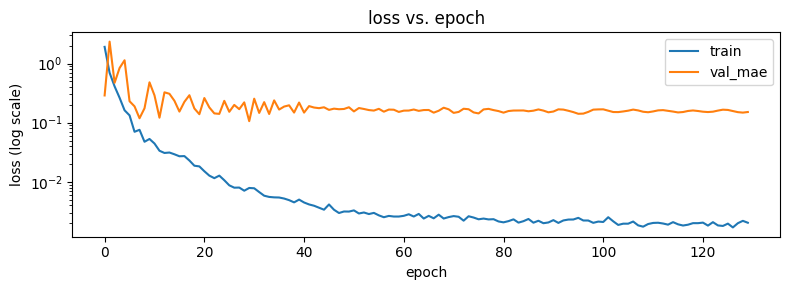

In [6]:
# training with scheduled sampling

os.makedirs('models', exist_ok=True)
model_path = 'models/tranformer_forecast.pth'
num_epochs = 200
teacher_prob = 1.0; min_teacher_prob = 0.1
decay = 0.98 # per epoch multiplicative decay (aggresive -> slower)

loss_fn = torch.nn.SmoothL1Loss() # robust to outliers
optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-3,
    weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer,
    mode='min', factor=0.7, patience=10)
early_stopping = EarlyStopping(patience=100, min_delta=1e-6)

history = {'train_loss': [], 'val_loss': []}
best_val = float('inf')
start_time = time.time()
for _ in range(1, num_epochs+1):
    train_loss = train_step_scheduled(model=model, dl_train=dl_train,
        loss_fn=loss_fn, optimizer=optimizer, device=device,
        teacher_forcing_prob=teacher_prob)
    history['train_loss'].append(train_loss)

    # evaluation: autoregressive (as inference)
    preds, trues = evaluate_autoregressive(model=model, dl=dl_test,
        device=device)
    # MAE on scaled domain
    val_loss = float(np.mean(np.abs(preds - trues)))
    history['val_loss'].append(val_loss)

    scheduler.step(val_loss)
    if val_loss < best_val:
        best_val = val_loss
        torch.save(obj=model.state_dict(), f=model_path)

    early_stopping(loss=val_loss)
    if early_stopping.early_stop:
        break

    teacher_prob = max(min_teacher_prob, teacher_prob * decay)

total_time = time.time() - start_time
print("Training finished in %.2fs, best_val=%.6f"%(total_time, best_val))

# Plot training history
plot_history(history=history)

### Inference

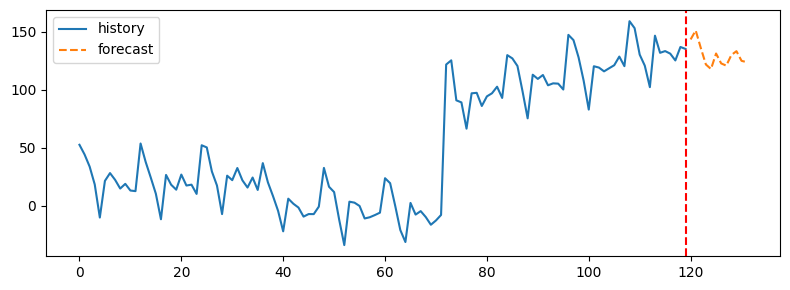

In [8]:
# load best model
model = TransformerForecast(num_in_features=3, num_out_features=1,
    d_model=128, time_emb_dim=16, nhead=4, num_layers=2, dropout=0.15)\
    .to(device)
model.load_state_dict(torch.load(f=model_path, weights_only=True))

# Full inference on the original full time series using sliding windows
# Build sliding window inputs across the full scaled series
ts_scaled = scaler.transform(X=ts_history.reshape(-1, 1)).flatten()
len_idx = len(ts_scaled) - src_len  + 1
idx = np.arange(stop=len_idx).reshape(-1, 1) + np.arange(stop=src_len)

data = {}
data['src'] = torch.tensor(data=ts_scaled[idx], dtype=torch.float32)\
    .unsqueeze(dim=-1) # (N_windows, src_len, 1)
data['src_idx'] = torch.tensor(data=idx, dtype=torch.long)
# rolling stats for full series to slice per-window
roll3 = pd.Series(ts_scaled).rolling(3, min_periods=1)\
    .mean().values.astype(np.float32)
roll6 = pd.Series(ts_scaled).rolling(6, min_periods=1)\
    .mean().values.astype(np.float32)
src_rm3 = np.stack([roll3[i:i+src_len] for i in range(len_idx)], axis=0)
src_rm6 = np.stack([roll6[i:i+src_len] for i in range(len_idx)], axis=0)
data['src_rm3'] = torch.tensor(src_rm3, dtype=torch.float32).unsqueeze(-1)
data['src_rm6'] = torch.tensor(src_rm6, dtype=torch.float32).unsqueeze(-1)

# we will run inference in batches to avoid memory blowup
B = 128
all_preds = []
model.eval()
for i in range(0, data['src'].size(0), B):
    batch = {
        'src': data['src'][i:i+B].to(device),
        'src_idx': data['src_idx'][i:i+B].to(device),
        'src_rm3': data['src_rm3'][i:i+B].to(device),
        'src_rm6': data['src_rm6'][i:i+B].to(device),
    }
    # (b, tgt_len, 1)
    with torch.no_grad():
        pred = model.infer(batch, tgt_len=tgt_len, device=device)
        all_preds.append(pred.cpu().numpy())

# (N_windows, tgt_len, 1)
all_preds = np.concatenate(all_preds, axis=0)
# pick the windows that correspond to forecasting beyond the original history
# Specifically, we want windows where the last source index
# For simplicity, compute forecast using the last available window
last_window_pred = all_preds[-1].squeeze(-1)  # (tgt_len,)
# inverse transform
last_window_pred_unscaled = scaler.inverse_transform(
    last_window_pred.reshape(-1, 1)).flatten()

time_pred = np.arange(time_history[-1] + 1 - tgt_len + tgt_len,
    time_history[-1] + 1 + tgt_len)
future_time = np.arange(time_history[-1] + 1, time_history[-1] + 1 + tgt_len)

plt.figure(figsize=(8, 3))
sns.lineplot(x=time_history, y=ts_history, label='history')
sns.lineplot(x=future_time, y=last_window_pred_unscaled, label='forecast', linestyle='--')
plt.axvline(x=time_history[-1], color='red', linestyle='--')
plt.legend(loc='best')
plt.tight_layout()
plt.show()